Instituto Politécnico Nacional

Centro de Investigación en Computación

Minería de datos I

Programa de Regresor de árbol de decisión.

Presenta: Ana Maritza Bello

---

# Regresor de árbol de decisión para la predicción de la ocurrencia de albatros de Layssan en el Pacífico

Con el fin de aplicar los criterios de evaluación de los modelos de regresión en
los datos propios trabajados durante el curso, se implementa un programa que
permite generar un modelo de regresión de árbol de decisión.

El objetivo del programa es predecir la ocurrencia de albatros de Layssan en el 
Pacífico, a partir de las variables ambientales.

El dataset de trayectorias de albatros de Layssan en el Pacífico contiene
registros de ocurrencia de la especie en un punto geográfico, así como las 
variables ambientales que se consideran relevantes para la ocurrencia de la
especie. El dataset contiene las siguientes columnas:

1. `name                        ` de tipo `object`
1. `spheroid_dist_to_colony     ` de tipo `float64`
1. `sst                         ` de tipo `float64`
1. `wnd_ucmp_height_above_ground` de tipo `float64`
1. `wnd_vcmp_height_above_ground` de tipo `float64`
1. `date                        ` de tipo `object `
1. `season                      ` de tipo `int64  `
1. `latitude                    ` de tipo `float64`
1. `longitude                   ` de tipo `float64`

Los problemas de regresión se caracterizan por tener una variable dependiente
continua, es decir, que puede tomar cualquier valor dentro de un rango. En este
caso, el problema es de multi-salida, ya que al quere predecir la ocurrencia de
una especie en un punto geográfico, se tienen dos variables dependientes, la
**longitud** y la **latitud**.

Las variables independientes son: `spheroid_dist_to_colony`, `sst`,
`wnd_ucmp_height_above_ground`, `wnd_vcmp_height_above_ground`, `date`,
`season`.

A partir de la columna `date` se generan las columnas `month` y `year` para
poder utilizarlas como variables independientes.

La variable categoricas `season` se convirtió en una variable numérica con la
ayuda de la función `LabelEncoder` de la librería `sklearn.preprocessing`. Esta
función asigna un número a cada categoría.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
data = pd.read_csv('../data/trajectories.csv')
data = data.drop(['id'],axis = 1)

df = pd.DataFrame(data)

# Preparación de los datos

In [75]:
df['month'] = df['date'].apply(lambda x: x.split('-')[1])
df['month'] = df['month'].astype(int)
df['year'] = df['date'].apply(lambda x: x.split('-')[0])
df['year'] = df['year'].astype(int)

In [76]:
# Transform categorical variables into one-hot encoding

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['season'] = le.fit_transform(df['season'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176767 entries, 0 to 176766
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   name                          176767 non-null  object 
 1   spheroid_dist_to_colony       176767 non-null  float64
 2   sst                           176766 non-null  float64
 3   wnd_ucmp_height_above_ground  176767 non-null  float64
 4   wnd_vcmp_height_above_ground  176657 non-null  float64
 5   date                          176767 non-null  object 
 6   season                        176767 non-null  int64  
 7   latitude                      176767 non-null  float64
 8   longitude                     176767 non-null  float64
 9   month                         176767 non-null  int64  
 10  year                          176767 non-null  int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 14.8+ MB


In [77]:
rows = df.isna().any(axis=1)
rows = rows[rows == True]
df.dropna(inplace=True)
rows = df.isna().any(axis=1)
df.isna().sum()

name                            0
spheroid_dist_to_colony         0
sst                             0
wnd_ucmp_height_above_ground    0
wnd_vcmp_height_above_ground    0
date                            0
season                          0
latitude                        0
longitude                       0
month                           0
year                            0
dtype: int64

# Matriz de correlación

Se calcula la matriz de correlación de las variables independientes con el fin
de identificar las variables que tienen una correlación alta con la variable
dependiente. En este caso, se considera que una correlación alta es aquella que
tiene un valor absoluto mayor a 0.5.

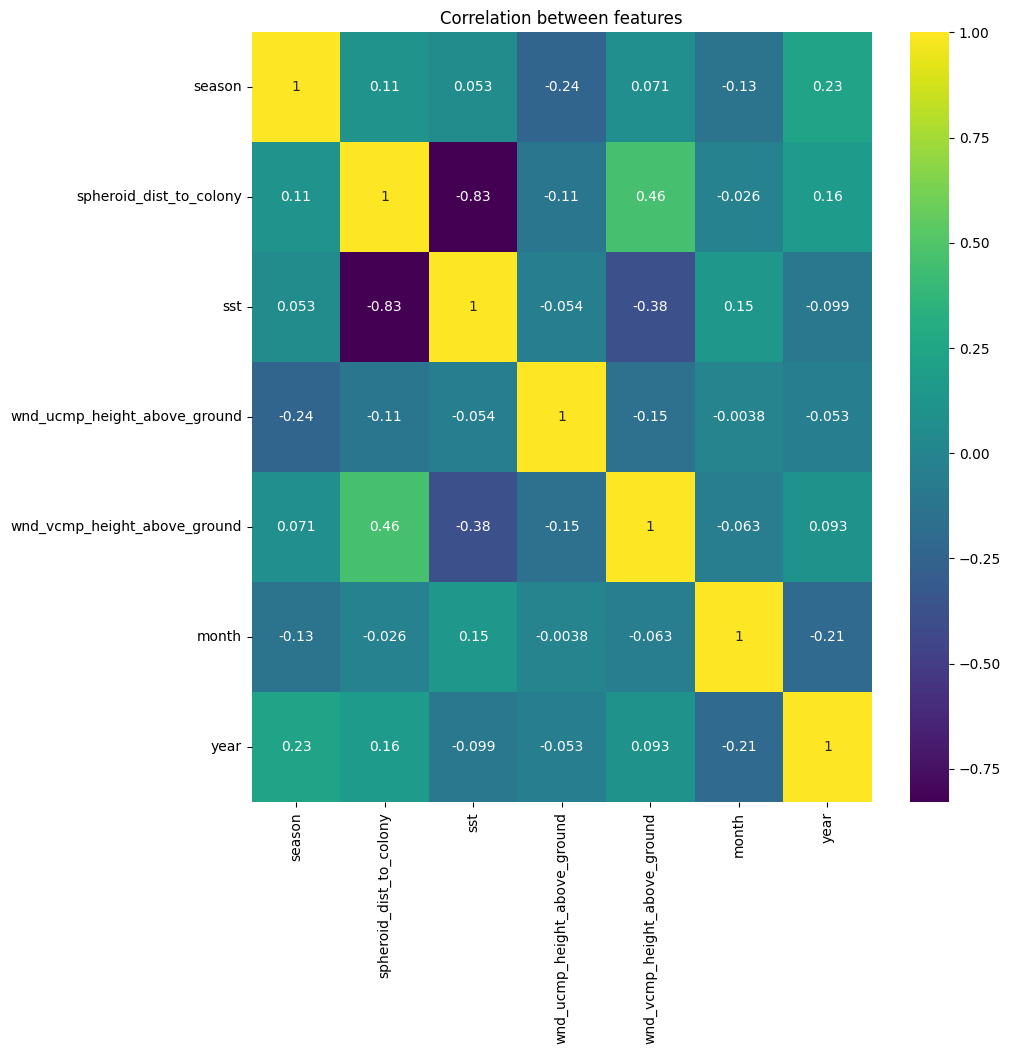

In [78]:
# Correlation between features
feature_cols = ['season', 'spheroid_dist_to_colony', 'sst', 'wnd_ucmp_height_above_ground', 'wnd_vcmp_height_above_ground', 'month', 'year']
corr = df[feature_cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.title('Correlation between features')
plt.show()


## Creación del modelo

Se crea el modelo de regresión de árbol de decisión utilizando la librería de
`sklearn.tree.DecisionTreeRegressor`. Se utiliza la función `train_test_split`
para dividir el dataset en un conjunto de entrenamiento y un conjunto de prueba.

## Parámetros del modelo

Se utilizan los siguientes parámetros para el modelo:

1. `criterion`: mide la calidad de la división. Los criterios soportados son
   `mse` para el error cuadrático medio, que es el utilizado en este caso.

1. `max_depth`: la profundidad máxima del árbol. Si no se especifica, los
   nodos se expanden hasta que todas las hojas contengan menos de
   `min_samples_split` muestras. El valor utilizado en este caso es **12**.

## Evaluación del modelo

Se evalúa el modelo utilizando las métricas de error cuadrático medio (**MSE**)
y error medio absoluto (**MAE**). También se calculó el coeficiente de
determinación (**R2 score**), que indica qué tan bien se ajustan los datos a la
recta de regresión. El valor de este coeficiente está entre 0 y 1, donde 1
indica que los datos se ajustan perfectamente a la recta de regresión.

# Creación de la variable dependiente multi-salida

Se crea la variable dependiente multi-salida creando un arreglo a partir de las columnas `latitude` y `longitude`.

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor

In [80]:
# Multitarget array
y = df[['longitude', 'latitude']].values

# Features
cols_to_drop = ['latitude', 'longitude', 'name', 'date']
X = df.drop(cols_to_drop, axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [81]:
multioutput_model = MultiOutputRegressor(DecisionTreeRegressor(max_depth=12, random_state=123))

multioutput_model.fit(X_train, y_train)

y_pred = multioutput_model.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

print('R2 score:', r2_score(y_test, y_pred))


Mean Absolute Error: 0.16722257545391617
Mean Squared Error: 0.1319478466949506
Root Mean Squared Error: 0.36324626177698044
R2 score: 0.9955760729177052


## Resultados

Se presenta una gráfica de los valores reales y los valores predichos por el
modelo. Se puede observar que los valores predichos se encuentran muy cercanos a
los valores reales.

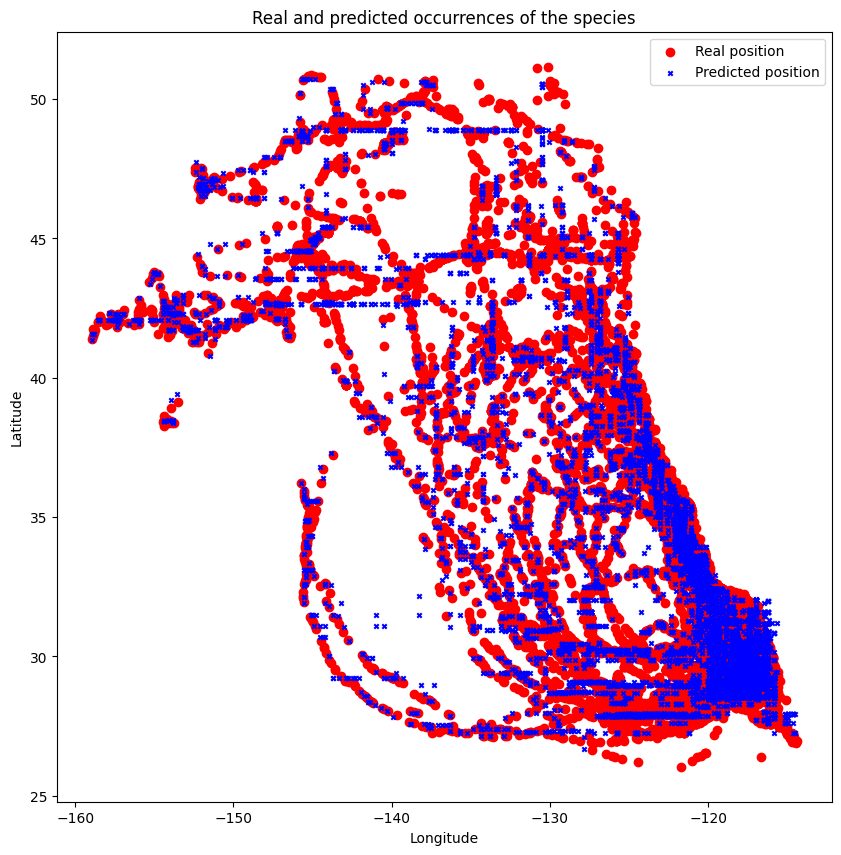

In [82]:
# Plot data and model prediction

plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='red', label='Real position')
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Predicted position', s=10, marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Real and predicted occurrences of the species')
plt.legend()

# Árbol de decisión

Se presenta el árbol de decisión generado por el modelo. 

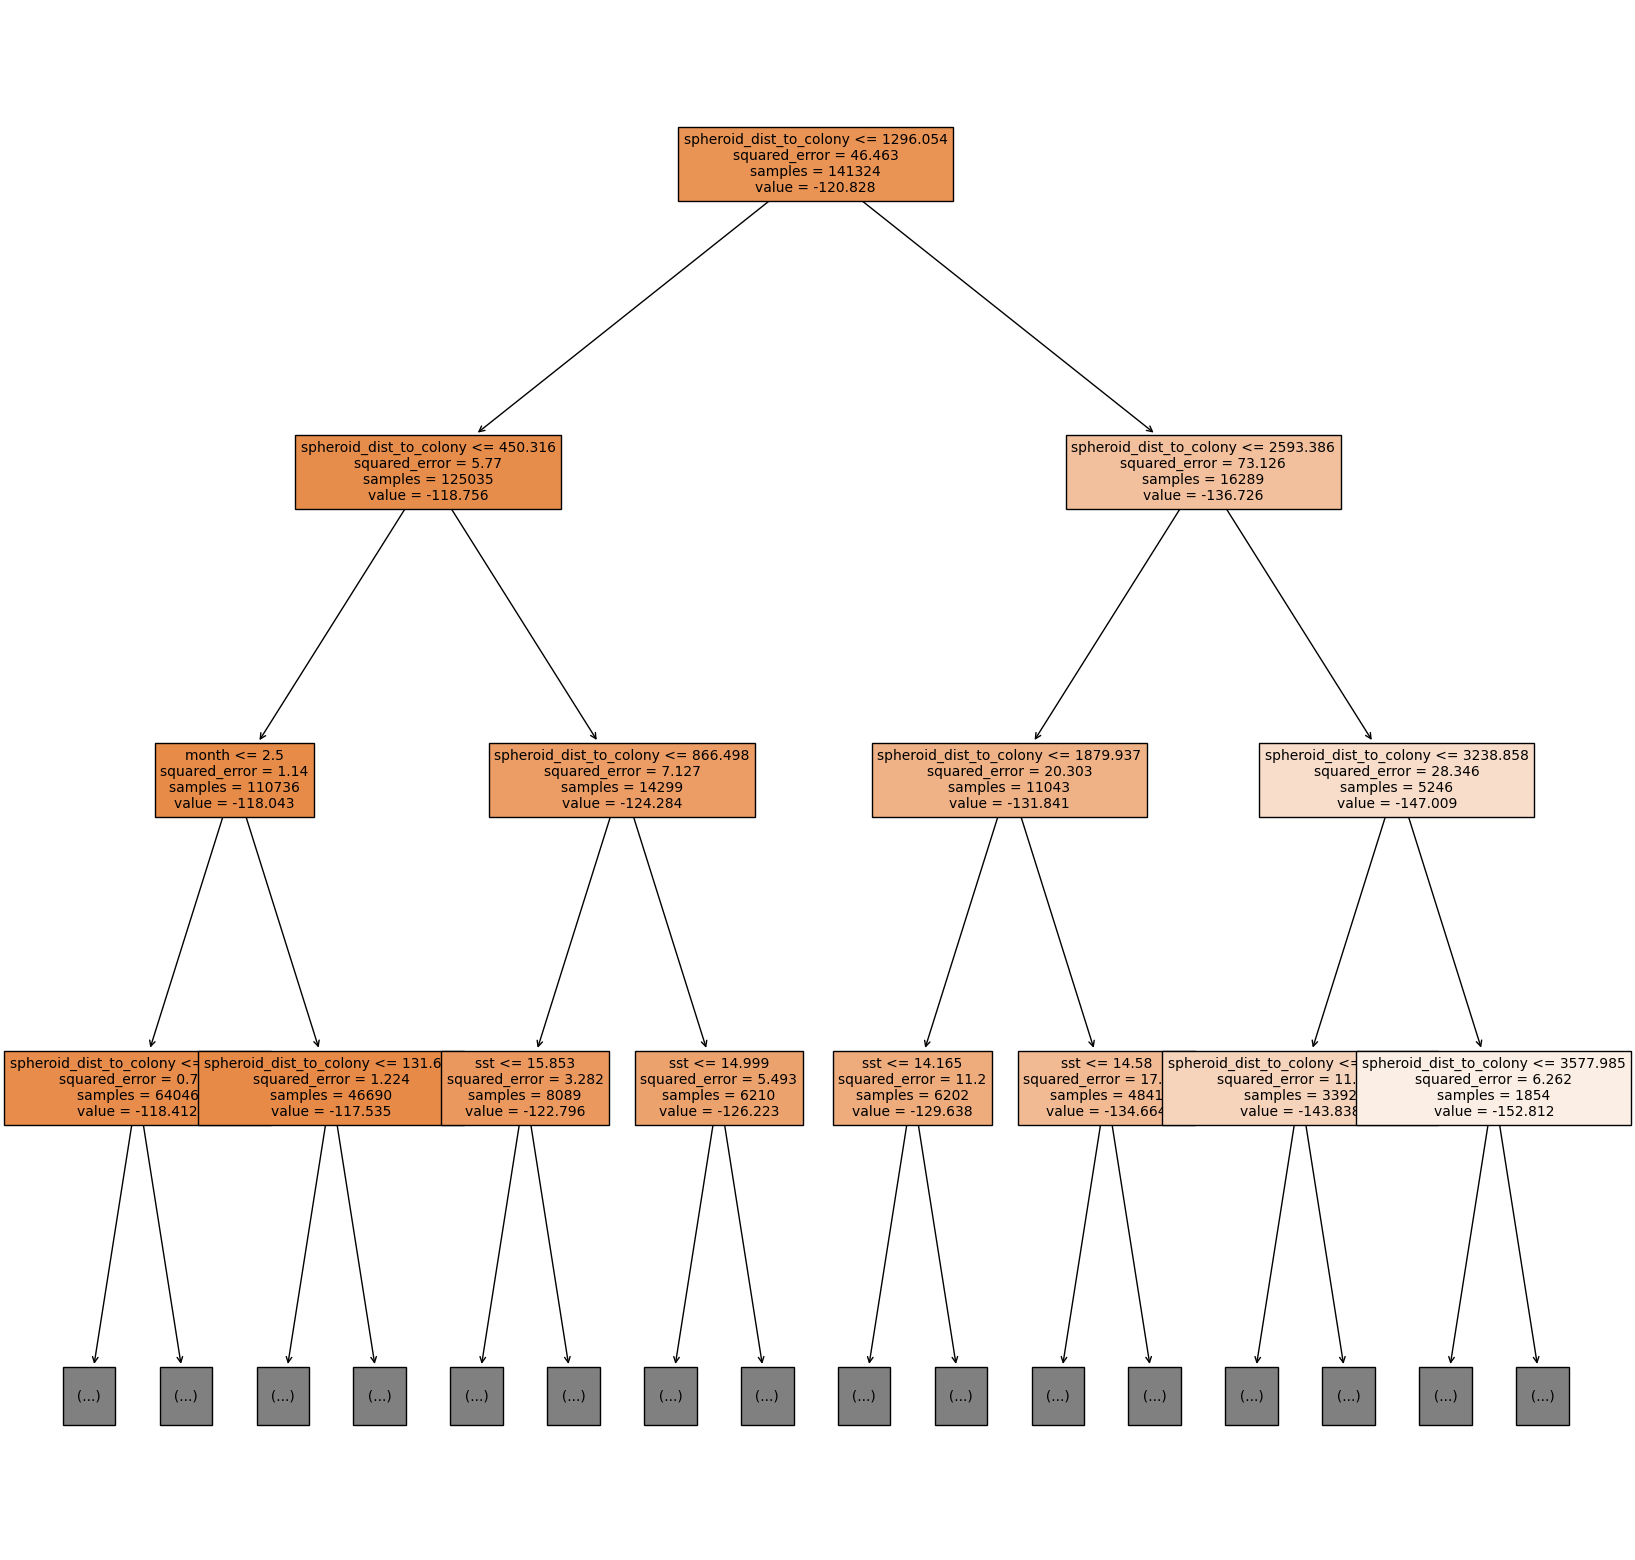

In [83]:
# Plot tree

plt.figure(figsize=(20, 20))
plt.title('Decision tree')
plot_tree(multioutput_model.estimators_[0], filled=True, feature_names=df.drop(cols_to_drop, axis = 1).columns, max_depth=3, fontsize=10)
plt.show()